In [84]:
# Generating some simple photon count data
import numpy as np
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 1000                     # true flux, say number of photons measured in 1 second
N = 50                        # number of measurements
F = stats.chi2(F_true).rvs(N)      # N measurements of the flux
e = np.sqrt(F)                    # errors on Poisson counts estimated via square root

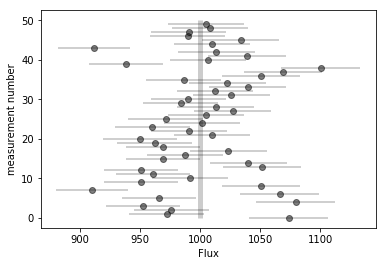

In [85]:
# show the results
fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux");ax.set_ylabel("measurement number");
plt.show()

In [86]:
# estimate the f value
estimated_f = (e**2 * F).sum() / (e**2).sum()
print('Ground Truth f : ', F_true)
print('Estimated f    : ', estimated_f)
print("Error Bound +/-: ",  (1./e**2).sum() ** -0.5)

Ground Truth f :  1000
Estimated f    :  1002.8654341692877
Error Bound +/-:  4.470687512531004


In [88]:
# define some method for sampling
def log_posterior (theta, F, e): return log_prior(theta) + log_likelihood(theta, F, e)
def log_likelihood(theta, F, e): return -0.5 * np.sum(np.log(2 * np.pi * e ** 2) + (F - theta[0]) ** 2 / e ** 2)
def log_prior(theta):            return 1  # flat prior

In [89]:
# MCMC sampling
ndim      = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn  = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

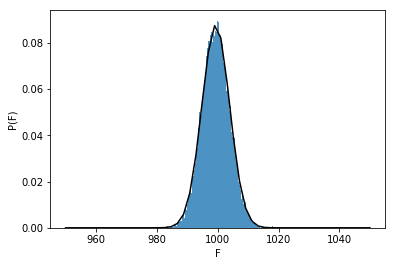

In [102]:
# plot a histogram of the sample
plt.hist(sample,bins='auto', alpha=0.8, density=True)

# plot a best-fit Gaussian
F_fit = np.linspace(950, 1050)
pdf   = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)
plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel("P(F)")
plt.show()

# Reference
1. scipy.stats.chi2 — SciPy v1.1.0 Reference Guide. (2018). Docs.scipy.org. Retrieved 13 November 2018, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2
2. 